### Introduction
This is a task assignment for Full Stack Developer at CeRDaS. The purpose of this task is to deploy Machine Learning (ML) model with **FastAPI and Docker.** The main goal is to develop a REST API that will be able to serve ML model predictions via HTTP Requests.

For this task, sentiment analysis has been selected as the main use case.

- **Sentiment Analysis** is the interpretation and classification of emotions (positive, neutral, negative) within text data using text analysis techniques. It allow us to identify public sentiment towards certain words or topics.

#### Importing Dependencies

In [1]:
# Utility
import re 
import pickle
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Natural Language Toolkit - NLTK
from nltk.stem import WordNetLemmatizer

# Scikit-learn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

#### Importing dataset

Dataset source: [sentiment140 dataset](https://www.kaggle.com/datasets/kazanova/sentiment140?datasetId=2477)

Dataset description:<br>
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api. The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment.

Dataset content:
- target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- ids: The id of the tweet (2087)
- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- flag: The query (lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (robotickilldozr)
- text: the text of the tweet (Lyx is cool)

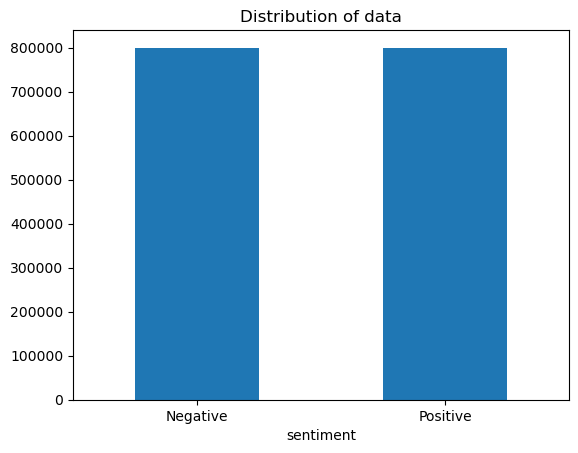

In [2]:
dataset_columns = ['sentiment', 'ids', 'date', 'flag', 'user', 'text']
dataset_encoding = 'ISO-8859-1'
dataset = pd.read_csv('./data/training.1600000.processed.noemoticon.csv', encoding=dataset_encoding, names=dataset_columns)

# Remove unnecessary columns
dataset = dataset[['sentiment', 'text']]

# Replacing the values to ease understanding
dataset['sentiment'] = dataset['sentiment'].replace(4, 1)

# Plotting the distribution of datasets
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data', legend=False)

# Adding the axis labels
ax.set_xticklabels(['Negative', 'Positive'], rotation=0)

# Storing data in lists
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

##### From the graph above, we can see that there are only two sentiment (Negative, Positive) which are divided equally in the dataset (80000).

#### Preprocess Text

The preprocessing steps are as follows:
- Lower Case: Convert the text to lower case.
- Replacing URLs: Replace all URLs with the text "URL".
- Replacing Emojis: Replace emojis with their text description. (Eg: ":)" to "happy")
- Replacing Usernames: Replace @Usernames with the text "USER".
- Replacing Non-Alphabets: Replace all non-alphabets characters with a space.
- Removing Consecutive letters: Remove consecutive letters which occur more than 2 times in the text. (Eg: "Heyyyy" to "Hey")
- Removing Short Words: Remove all words having length <= 2.
- Removing Stopwords: Remove all stopwords using NLTK stopwords list. (Eg: "the", "me", "a", etc)
- Lemmatization: Lemmatize the words to their base form. (Eg: "Great" to "Good")

In [3]:
# Emojis dictionary contains the key-value pairs of all the emojis and their respective meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

# Set of all the stopwords in the english language.
stopword_list = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [4]:
# Define function to preprocess text
def preprocess(textdata):
    processed_text = []

    # Create Lemmatizer and Stemmer.
    word_lemm = WordNetLemmatizer()

    # Define regex to remove pattern like url, user pattern, alpha pattern, etc.
    url_pattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)" 
    user_pattern       = '@[^\s]+'
    alpha_pattern      = "[^a-zA-Z0-9]"
    sequence_pattern   = r"(.)\1\1+"
    seq_replace_pattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower() # Lowercase

        # Remove URL
        tweet = re.sub(url_pattern,' ',tweet)

        # Replace all emojis with 'EMOJI' + description.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])

        # Remove username
        tweet = re.sub(user_pattern,' ', tweet)

        # Remove non alphabet.
        tweet = re.sub(alpha_pattern, ' ', tweet)

        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequence_pattern, seq_replace_pattern, tweet)

        tweetwords = ''

        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stop_words:
            if len(word)>1:
                # Lemmatizing the word.
                word = word_lemm.lemmatize(word)
                tweetwords += (word+' ')

        processed_text.append(tweetwords)

    return processed_text

In [5]:
import time
t = time.time()
processed_text = preprocess(text)
print(f'Time taken to preprocess: {round(time.time() - t)} seconds')

Time taken to preprocess: 52 seconds


#### Analysing the data

##### Word-cloud for Negative Tweets

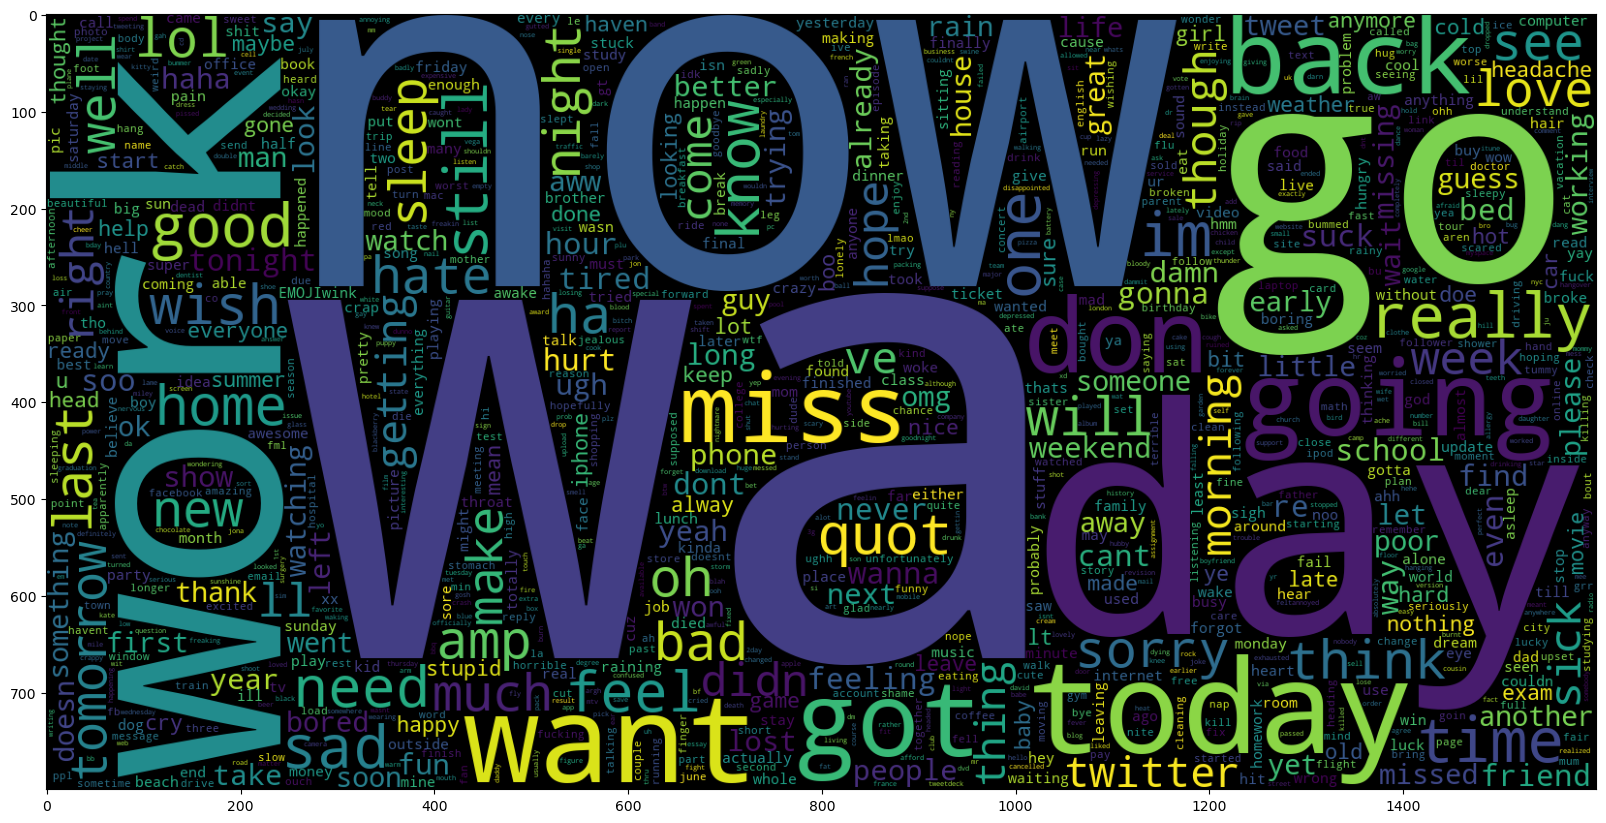

In [6]:
data_negative = processed_text[:800000] # Getting the first 800000 negative tweets
plt.figure(figsize=(20,20))
wordcloud = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(" ".join(data_negative))
plt.imshow(wordcloud)

##### Word-cloud for Positive Tweets

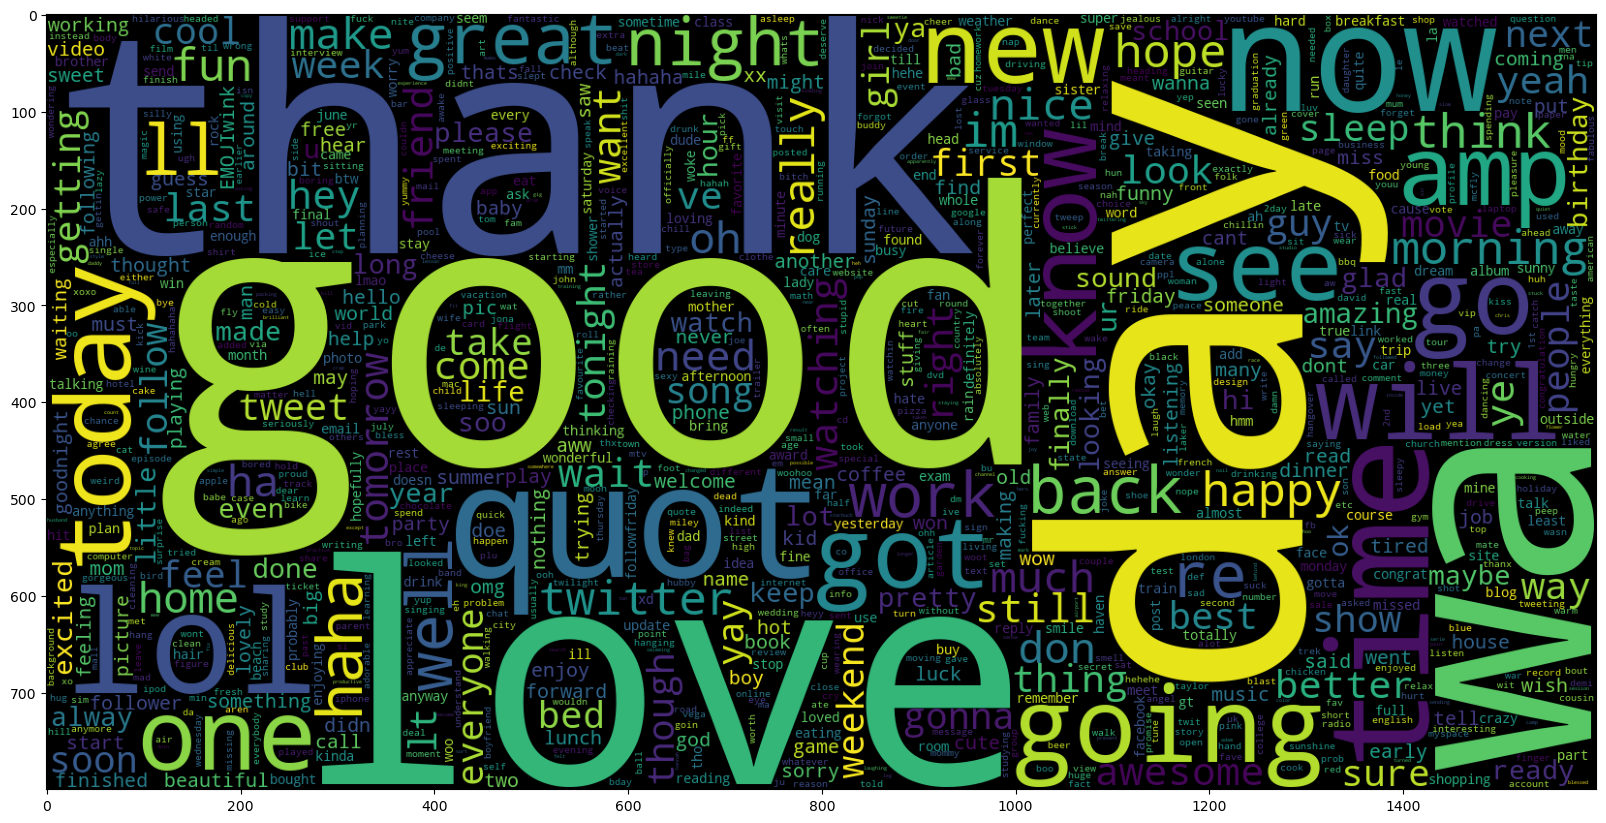

In [7]:
data_positive = processed_text[800000:] # Getting the second half of the data for positive tweets
plt.figure(figsize=(20,20))
wordcloud = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(" ".join(data_positive))
plt.imshow(wordcloud)

##### Splitting the dataset into the Training set and Test set
- Training data: 95%
- Test data: 5%

In [8]:
X_train, X_test, y_train, y_test = train_test_split(processed_text, sentiment, test_size = 0.05, random_state = 0)

print(f'Data Split done')

Data Split done


##### TF-IDF Vectorizer

Stands for Term Frequency-Inverse Document Frequency. It's a way to score the importance of words (or "terms") in a document, based on how frequently they appear across many documents.

Suppose I have a tweet about dogs, the word "dog" might appear a lot in the tweet but not as much in other tweets. TF-IDF will give the word "dog" a high TF-IDF score for importance in the document. Other tweets that contains other word than "dog" will have a lower TF-IDF score.

- TF-IDF Vectoriser converts a collection of raw documents to a matrix of TF-IDF features. It is trained only on X_train dataset.
- ngram_range is the range of number of words in a sequence. eg: "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)
- max_features is the maximum number of features to be extracted.


In [9]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)

print(f'Vectorizer fitted')
print('No. of feature_words: ', len(vectorizer.get_feature_names_out()))

Vectorizer fitted
No. of feature_words:  500000


##### Transforming the dataset


In [10]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

print(f'Data Transformed')

Data Transformed


##### Creating and Evaluating Models
1. Bernoulli Naive Bayes (BernoulliNB)
2. Linear Support Vector Machine (LinearSVC)
3. Logistic Regression (LogisticRegression)

In [11]:
def model_evaluate(model):
    # Predict the values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '', xticklabels = categories, yticklabels = categories)

    plt.xlabel('Predicted values', fontdict = {'size':14}, labelpad = 10)
    plt.ylabel('Actual values', fontdict = {'size':14}, labelpad = 10)
    plt.title ('Confusion Matrix', fontdict = {'size':18}, pad = 20)

##### Model #1: Bernoulli Naive Bayes (BernoulliNB)

              precision    recall  f1-score   support

           0       0.81      0.78      0.80     39989
           1       0.79      0.82      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



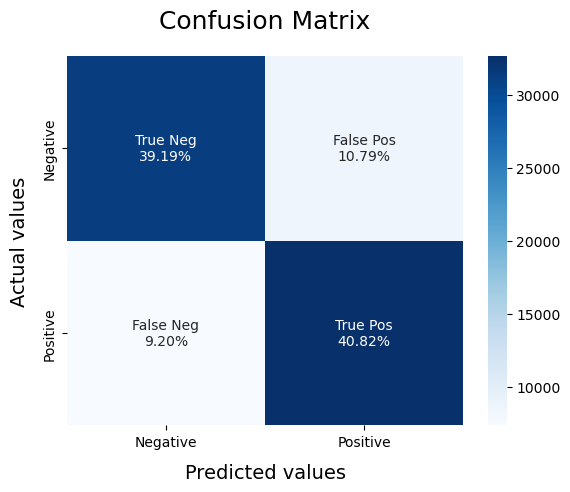

In [12]:
bernoullinb_model = BernoulliNB(alpha = 2)
bernoullinb_model.fit(X_train, y_train)
model_evaluate(bernoullinb_model)

##### Model #2: Linear Support Vector Machine (LinearSVC)

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     39989
           1       0.81      0.82      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



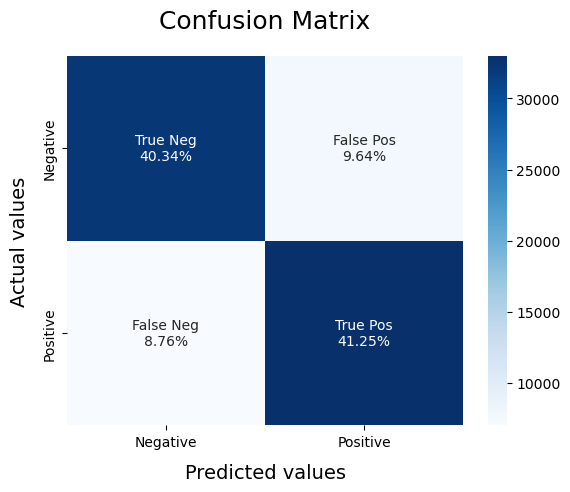

In [13]:
linearsvc_model = LinearSVC()
linearsvc_model.fit(X_train, y_train)
model_evaluate(linearsvc_model)

##### Model #3: Logistic Regression (LogisticRegression)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



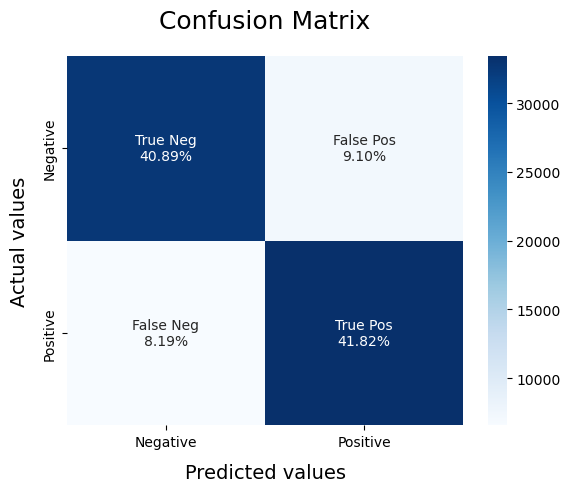

In [14]:
logisticreg_model = LogisticRegression(C = 2, max_iter = 1000, n_jobs = -1)
logisticreg_model.fit(X_train, y_train)
model_evaluate(logisticreg_model)

Conclusion:<br>
- Logistic Regression Model performs the best out of all models - 83% accuracy.
- However, Bernoulli Naive Bayes Model is the fastest model to train and predict. - 80% accuracy.

##### Saving the Models

In [15]:
file = open('./models/vectorizer-ngram-(1,2).pickle', 'wb')
pickle.dump(vectorizer, file)
file.close()

file = open('./models/sentiment-logisticreg.pickle', 'wb')
pickle.dump(logisticreg_model, file)
file.close()

file = open('./models/sentiment-bernoullinb.pickle', 'wb')
pickle.dump(bernoullinb_model, file)
file.close()

##### Using the Model
- Import the vectorizer and the logistic regression model using Pickle
- The vectorizer can be used to transform data to matrix of TF-IDF features. 

The sentiment is: Positive


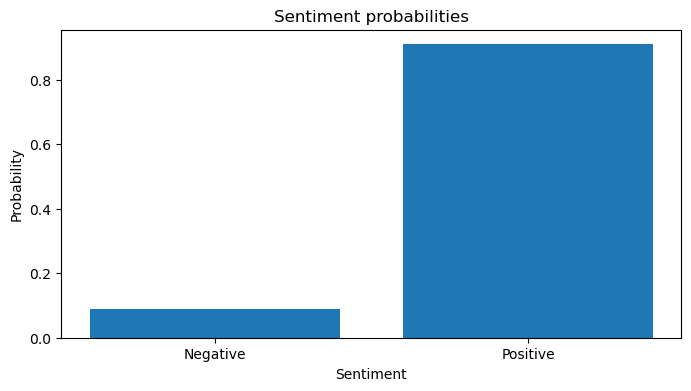

In [16]:
def load_models():
    
    # Load the vectorizer
    file = open('./models/vectorizer-ngram-(1,2).pickle', 'rb')
    vectorizer = pickle.load(file)
    file.close()

    # Load the Logistic Regression Model
    file = open('./models/sentiment-logisticreg.pickle', 'rb')
    logistic_regression = pickle.load(file)
    file.close()

    return vectorizer, logistic_regression

def predict(vectorizer, model, text):

    # Predict the sentiment
    text_data = vectorizer.transform(preprocess([text]))
    sentiment = model.predict(text_data)

    # return sentiment
    if sentiment[0] == 0:
        return 'Negative'
    else:
        return 'Positive'

if __name__=='__main__':
    
    # Loading the models.
    vectorizer, logistic_regression = load_models()

    # Predict the sentiment
    text = "I feel so happy today!"
    sentiment = predict(vectorizer, logistic_regression, text)

    print(f"The sentiment is: {sentiment}")

    # Predict probabilities
    text_vector = vectorizer.transform([text])
    probabilities = logistic_regression.predict_proba(text_vector)[0]

    # Plot probabilities
    plt.figure(figsize=(8, 4))
    plt.bar(['Negative', 'Positive'], probabilities)
    plt.title('Sentiment probabilities')
    plt.xlabel('Sentiment')
    plt.ylabel('Probability')
    plt.show()